# IA para el diagnóstico de radiografías de torax


Este proyecto aborda la clasificación de imágenes de rayos X utilizando técnicas avanzadas de aprendizaje profundo. A través de este trabajo, se implementará un clasificador de imágenes basado en la arquitectura DenseNet121 mediante el uso de transfer learning. El objetivo principal es diagnosticar patologías pulmonares utilizando un conjunto de datos de rayos X, y se emplean varias técnicas para mejorar el rendimiento del modelo.

Para visualizar los resultados obtenidos y añadir explicabilidad, se usará la técnica de GradCAM que nos ayudará a entender que partes de las imágenes han tomado relevancia para tomar las decisiones.

## Index

- [1. Import de paquetes y funciones](#1)
- [2. Load the Datasets](#2)
    - [2.1. Proceso de carga de datasets](#2-1)
- [3. Data Development](#3)
    - [3.1. Fuga de datos](#3-1)
    - [3.2. Preparar las imágenes y aplicar data augmentation](#3-2)
    - [3.3. Balance de clases](#3-3)
    - [3.4. Función de pérdida ponderada](#3-4)
- [4. Desarrollo del modelo - DenseNet121](#4)
    - [4.1. Ajuste de hiperparámetros usando libreria Optuma](#4-1)
    - [4.2. Definición de Callbacks y entrenamiento del modelo optimizado](#4-2)
    - [4.3. Guardar y cargar modelo](#4-3)
- [5. Predicción y evaluacion](#5)
    - [5.1. Curva ROC y AUROC](#5-1)
- [6. Productivizar el modelo](#6)
    - [6.1. Visualización de muestras con GradCAM](#6-1)

<a name='1'></a>
## 1. Import de paquetes y funciones

Para este proyecto, utilizaremos los siguientes paquetes:

- `numpy` y `pandas` para la manipulación y análisis de los datos.
- `seaborn` y `matplotlib.pyplot` para la visualización de datos a través de gráficos.
- `tensorflow` y varios módulos de `keras` para la construcción y entrenamiento de modelos de deep learning, incluyendo:
- `ImageDataGenerator` para la generación de lotes de imágenes con aumentos.
- `DenseNet121` para utilizar una red preentrenada como base del modelo.
- `GlobalAveragePooling2D`, `Dense`, `Dropout` para añadir capas a la red.
- `Model` para crear el modelo y `load_model` para cargar modelos preentrenados.
- Callbacks como `ModelCheckpoint`, `TensorBoard`, `ReduceLROnPlateau`, y  `EarlyStopping` para mejorar el proceso de entrenamiento.
`Adam` para la optimización del modelo y `backend` para operaciones de bajo nivel con Keras.
- `optuna` para la optimización de hiperparámetros durante el entrenamiento del modelo.
- `os` para la manipulación de directorios y archivos..
- `drive` para hacer uso de carpetas compartidas en google collab.
- `Image` de la librería PIL para mostrar imágenes.


In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.8 MB/s eta 0:00:00


In [2]:
# Imports ajustados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.utils import load_img, img_to_array

import optuna
import os
from google.colab import drive
from PIL import Image

import cv2

<a name='2'></a>
## 2. Load the Datasets

Este proyecto, esta basado en un dataset que contiene 108.948 imagenes de 32,717 pacientes(https://arxiv.org/abs/1705.02315). Sin embargo nosotros trabajaremos con un dataset mucho más reducido de este conjunto, el cúal tendremos la información del diagnositco de este subconjunto.

- Cada imagen del conjunto de datos contiene varias etiquetas de texto que identifican 14 patologías distintas.

- Para cada una de esas patologías estamos intentando predecir si una determinada condición está presente (es decir, 1) o ausente (es decir, 0).

- El modelo, hará predicciones de estas patologías para cada uno de los casos.

Estos serán los 3 conjuntos de datos con los que trabajaremos.

- 875 imágenes para training.
- 109 imágenes para validación.
- 420 imágenes para testing.



<a name='2-1'></a>
### 2.1 Proceso de carga de datasets

In [3]:
# Uso de carpetas compartidas en google drive para cargar ficheros
drive.mount('/content/drive')

# Creacion de rutas en variables
# HOME_DIR = "/content/drive/MyDrive/0 - TFM/home"
DATA_DIR = HOME_DIR
IMAGE_DIR = HOME_DIR + "/data/images-small/"

#Carga de datasets
train_df = pd.read_csv(HOME_DIR + "/data/train-small.csv")
valid_df = pd.read_csv(HOME_DIR + "/data/valid-small.csv")
test_df = pd.read_csv(HOME_DIR + "/data/test.csv")

# Guardamos en labels todas las etiquetas que tendrá nuestro dataset.
labels = ['Cardiomegaly', 'Emphysema','Effusion','Hernia','Infiltration','Mass','Nodule','Atelectasis','Pneumothorax','Pleural_Thickening','Pneumonia','Fibrosis','Edema','Consolidation']

Mounted at /content/drive


Como podemos ver, nuestro dataset, contiene el PatienId y las patologías asociadas a cada imagen, siendo 1 el caso afirmativo.

In [4]:
train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


Si hacemos un muestreo de una imágen, podemos ver que esta no está normalizada:

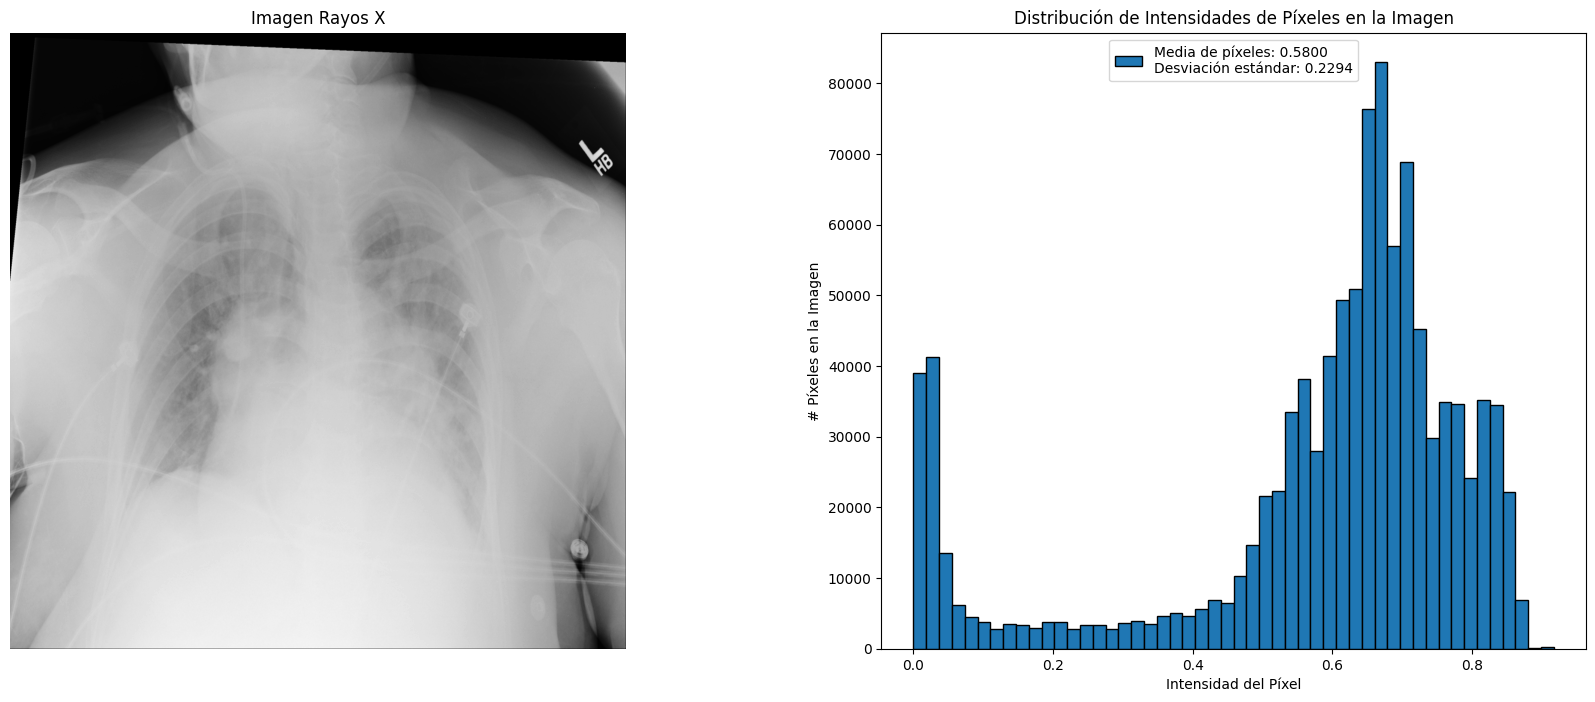

In [5]:
# Obtener la primera imagen listada en el DataFrame
sample_img = train_df.Image[5]
raw_image = plt.imread(os.path.join(IMAGE_DIR, sample_img))

# Calcular estadísticas
mean_raw = np.mean(raw_image)
std_raw = np.std(raw_image)

# Crear la figura con subgráficos
fig, axs = plt.subplots(1, 2, figsize=(18, 8))  # Ajusta el tamaño de la figura según sea necesario

# Configurar la paleta de colores de Seaborn
sns.set_palette("Set3")

# Primer gráfico: Imagen
axs[0].imshow(raw_image, cmap='gray')
axs[0].grid(color='w', linestyle='-', linewidth=1)
axs[0].set_title('Imagen Rayos X')
axs[0].axis('off')

# Segundo gráfico: Histograma
pixels = raw_image.reshape(-1)  # Aplana la imagen a un vector
axs[1].hist(pixels, bins=50, edgecolor='black')
axs[1].set_title('Distribución de Intensidades de Píxeles en la Imagen')
axs[1].set_xlabel('Intensidad del Píxel')
axs[1].set_ylabel('# Píxeles en la Imagen')
axs[1].legend([f'Media de píxeles: {mean_raw:.4f}\nDesviación estándar: {std_raw:.4f}'], loc='upper center')

# Ajustar el espacio entre los subgráficos
plt.subplots_adjust(left=0.05, right=0.95, wspace=0.3)  # Ajusta los márgenes y el espacio entre gráficos
plt.show()


In [8]:
#Sacar CSV para Canvas
import csv
# Aplana la imagen en un vector de píxeles
pixels = raw_image.reshape(-1)

# Calcula el histograma con 50 bins
hist, bin_edges = np.histogram(pixels, bins=50)

# Crea un archivo CSV para exportar los datos del histograma
with open('histogram_raw_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Intensidad de Píxel', '# Píxeles'])

    # Recorre los valores del histograma y los bin_edges (bordes de los bins)
    for i in range(len(hist)):
        writer.writerow([f'{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}', hist[i]])

print("Datos exportados a 'histogram_raw_data.csv'")

Datos exportados a 'histogram_data.csv'


<a name='3'></a>
## 3. Data Development

En este segmento, vamos a tratar los datos, vamos a depurarlos, transformarlos y adaptarlos a lo que necesita nuestro modelo.


<a name='3-1'></a>
### 3.1. Fuga de datos

Uno de los problemas que tenemos que abordar en el caso de analizar imágenes medicas, es evitar que la radiografía de un mismo paciente, aparezca en los conjuntos de train y validation, y luego en el de test.

Nuestro modelo aprenderá que un paciente tiene ciertas patologías, si luego ese mismo paciente aparece en el proceso de test, simplemente tendrá que indicar que posee las mismas patologías que ya vio en el proceso de training o validation.

A este proceso se le denomina data leakeage o fuga de datos. Tendremos que corroborar que no se comparten los PatientID entre los dataset de train y validation con el dataset de test.

In [ ]:
#Funcion que checkea si se produce fuga de datos entre 2 dataset diferentes.

def comprobar_fugas(df1, df2, col):
    # Obtener los valores únicos de la columna especificada en ambos DataFrames
    df1_unicos = df1[col].unique()
    df2_unicos = df2[col].unique()

    # Convertir las listas de IDs únicos a conjuntos
    conjunto_df1 = set(df1_unicos)
    conjunto_df2 = set(df2_unicos)

    # Obtener la intersección de los dos conjuntos
    pacientes_en_ambos_grupos = conjunto_df1.intersection(conjunto_df2)

    # Si hay intersección, significa que hay superposición de pacientes
    if len(pacientes_en_ambos_grupos) == 0:
        fuga = False
    else:
        fuga = True

    return fuga

In [ ]:
#print("fuga entre train y valid: {}".format(check_for_leakage(train_df, valid_df, 'PatientId')))
print("Fuga entre train y test: {}".format(comprobar_fugas(train_df, test_df, 'PatientId')))
print("fuga entre valid y test: {}".format(comprobar_fugas(valid_df, test_df, 'PatientId')))

Fuga entre train y test: False
fuga entre valid y test: False


<a name='3-2'></a>
### 3.2. Preparar las imágenes y aplicar data-augmentation

Una vez que ya tenemos el conjunto de entrenamiento, validación y prueba, ahora trataremos las imágenes para que nuestro modelo pueda procesarlas. Para esto, emplearemos la clase ´ImageDataGenerator´ de Keras, que nos permite crear un generador de imágenes a partir de un marco de datos.

- Aplicaremos data augmentation, aplicando una inclinación aleatorio de las imágenes, lo que ayuda a mejorar la generalización del modelo.

- Este generador también normaliza los datos, ajustando cada lote de imágenes para que tenga una media de 0 y una desviación estándar de 1. Esto estandariza los valores y facilita el proceso de entrenamiento del modelo.

Además, las imágenes de rayos X, que están en formato de escala de grises (un solo canal), se convierten en imágenes de tres canales. Esto es necesario porque el modelo preentrenado que usaremos, como DenseNet121, requiere entradas de tres canales para funcionar correctamente

Lo que buscamos en este proceso es:

- Normalizar las imágenes, ajustando la media y desviación estandar.
- Aplicar un barajado de las imágenes despues de cada epoca.
- Readaptar las imágenes a una dimension de 320x320 para adaptarla al modelo.

Vamos a normalizar cada imagen por lote, lo que significa que utiliza estadísticas por lotes. El modelo no debería tener ninguna información sobre los datos de prueba, por lo que vamos a crear una función diferente para generar las imágenes de cada conjunto.

In [ ]:
def generador_train(df, directorio_imagenes, columna_x, columnas_y, barajar=True, tam_batch=8, seed=22, ancho=320, alto=320):

    print("Generador de entrenamiento...")

    # Definir la augmentación de datos y normalización
    generador_imagenes = ImageDataGenerator(
        rotation_range=20,               # Rotar imágenes aleatoriamente hasta 20 grados
        samplewise_center=True,          # Normalizar cada imagen por su media
        samplewise_std_normalization=True)  # Normalizar cada imagen por su desviación estándar

    # Flujo desde el directorio con el tamaño de batch y el tamaño de imagen objetivo especificados
    generador = generador_imagenes.flow_from_dataframe(
        dataframe=df,
        directory=directorio_imagenes,
        x_col=columna_x,
        y_col=columnas_y,
        class_mode="raw",
        batch_size=tam_batch,
        shuffle=barajar,
        seed=seed,
        target_size=(ancho, alto))

    return generador



In [ ]:
def generador_validation_test(df_validation, df_test, df_train, directorio_imagenes, columna_x, columnas_y, tam_muestra=100, tam_batch=8, seed=22, ancho=320, alto=320):

    print("Obteniendo generadores de validación y prueba...")

    # Obtener generador para muestrear el conjunto de datos de entrenamiento
    generador_raw_entrenamiento = ImageDataGenerator().flow_from_dataframe(
        dataframe=df_train,
        directory=directorio_imagenes,
        x_col=columna_x,
        y_col=columnas_y,
        class_mode="raw",
        batch_size=tam_muestra,
        shuffle=True,
        target_size=(ancho, alto))

    # Obtener una muestra de datos
    lote = next(generador_raw_entrenamiento)
    muestra_datos = lote[0]

    # Usar la muestra para ajustar la media y la desviación estándar para el generador del conjunto de prueba
    generador_imagenes = ImageDataGenerator(
        featurewise_center=True,            # Normalizar por la media general del conjunto de entrenamiento
        featurewise_std_normalization=True)  # Normalizar por la desviación estándar general del conjunto de entrenamiento

    # Ajustar el generador a la muestra de datos del conjunto de entrenamiento
    generador_imagenes.fit(muestra_datos)

    # Obtener generador para el conjunto de validación
    generador_validacion = generador_imagenes.flow_from_dataframe(
        dataframe=df_validation,
        directory=directorio_imagenes,
        x_col=columna_x,
        y_col=columnas_y,
        class_mode="raw",
        batch_size=tam_batch,
        shuffle=False,
        seed=seed,
        target_size=(ancho, alto))

    # Obtener generador para el conjunto de prueba
    generador_prueba = generador_imagenes.flow_from_dataframe(
        dataframe=df_test,
        directory=directorio_imagenes,
        x_col=columna_x,
        y_col=columnas_y,
        class_mode="raw",
        batch_size=tam_batch,
        shuffle=False,
        seed=seed,
        target_size=(ancho, alto))

    return generador_validacion, generador_prueba



Una vez que tenemos las funciones para preparar las imágenes definidas, voy generar las imágenes.

In [ ]:
train_generator = generador_train(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= generador_validation_test(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

Generador de entrenamiento...
Found 1000 validated image filenames.
Obteniendo generadores de validación y prueba...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


Vamos a ver como son las imágenes que hemos generado:

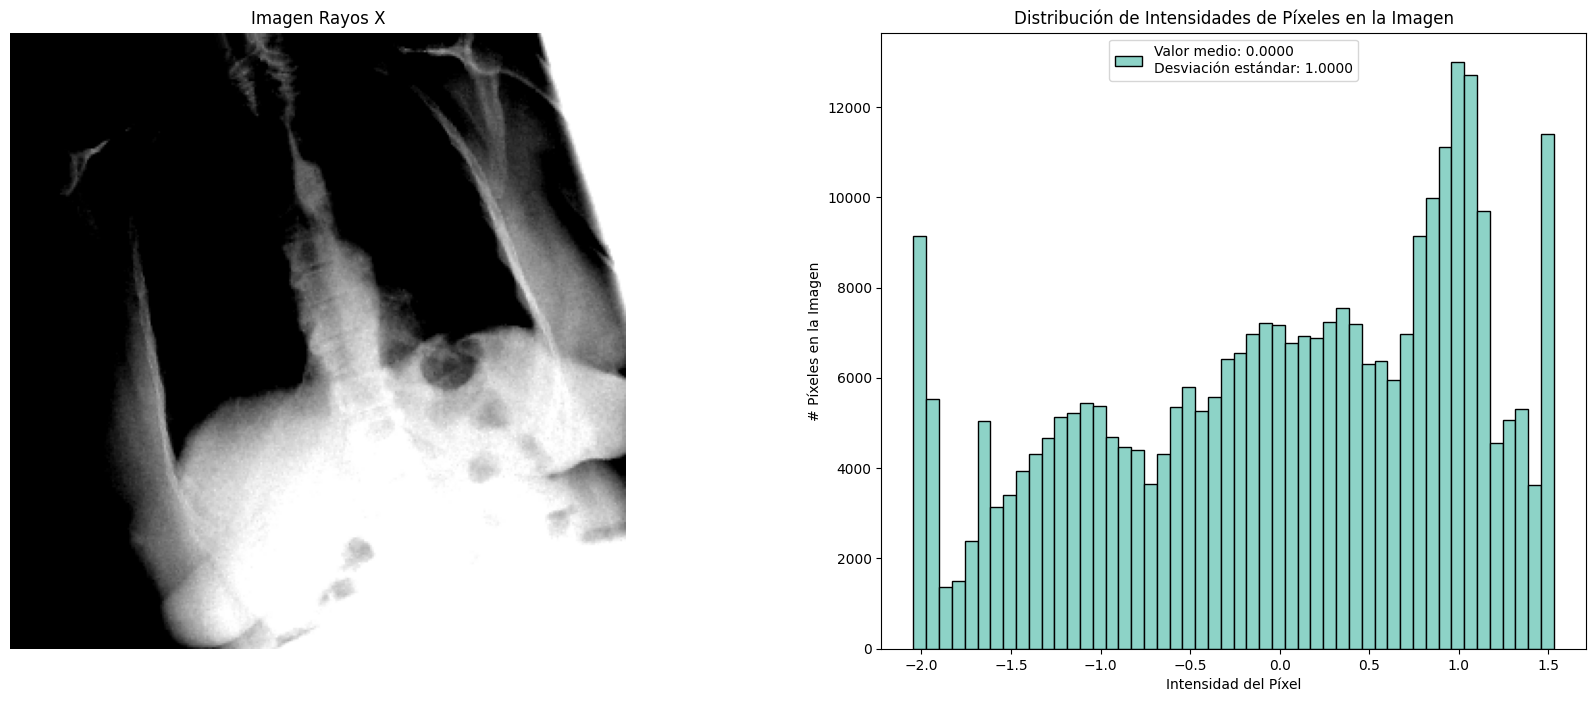

In [ ]:
# Obtener una imagen del generador de entrenamiento
sample_img, _ = next(train_generator)  # Obtén un batch de imágenes del generador
sample_img = sample_img[0]  # Selecciona la primera imagen del batch

# Calcular estadísticas
mean_raw = np.mean(sample_img)
std_raw = np.std(sample_img)

# Crear la figura con subgráficos
fig, axs = plt.subplots(1, 2, figsize=(18, 8))  # Ajusta el tamaño de la figura según sea necesario

# Configurar la paleta de colores de Seaborn
sns.set_palette("Set2")

# Primer gráfico: Imagen
axs[0].imshow(sample_img, cmap='gray')
axs[0].grid(color='w', linestyle='-', linewidth=1)
axs[0].set_title('Imagen Rayos X')
axs[0].axis('off')

# Segundo gráfico: Histograma
pixels = sample_img.reshape(-1)  # Aplana la imagen a un vector
axs[1].hist(pixels, bins=50, edgecolor='black')
axs[1].set_title('Distribución de Intensidades de Píxeles en la Imagen')
axs[1].set_xlabel('Intensidad del Píxel')
axs[1].set_ylabel('# Píxeles en la Imagen')
axs[1].legend([f'Valor medio: {mean_raw:.4f}\nDesviación estándar: {std_raw:.4f}'], loc='upper center')

# Ajustar el espacio entre los subgráficos
plt.subplots_adjust(left=0.05, right=0.95, wspace=0.3)  # Ajusta los márgenes y el espacio entre gráficos
plt.show()


Vemos como se han transformado las imágenes, se han rotado y muy importante, tenemos las imágenes normalizadas, con media 0 y desviación estándar 1.

<a name='3-3'></a>
### 3.3. Balance de clases

Uno de los retos de trabajar con conjuntos de datos de diagnóstico médico es el gran desequilibrio de clases que presentan.

Lo normal es trabajar con un conjunto de datos donde la mayoría de las imágenes de los pacientes no tengan las patologías que queremos identificar. Se peude dar el caso de que tan solo un porcentaje de menos del 10% de las imagenes tengan una patologia, produciendose un gran desbalance de los datos con el que entrenar el modelo.

Vamos a calcular la frecuencia de cada una de las etiquetas de nuestro conjunto de datos:

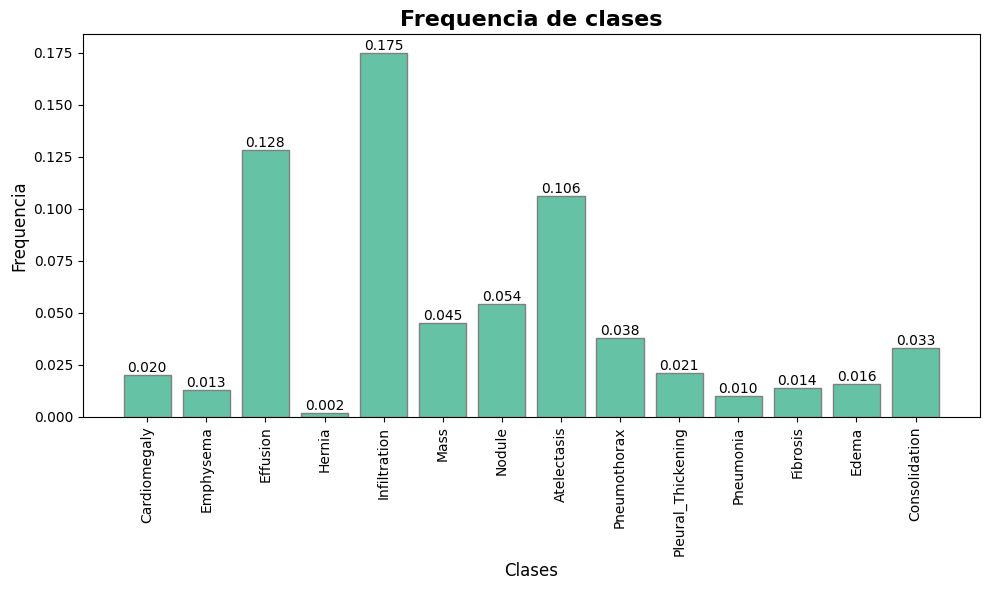

In [ ]:
# Calcula las frecuencias de cada clase
class_frequencies = np.mean(train_generator.labels, axis=0)

# Crear un tamaño de figura más grande
plt.figure(figsize=(10, 6))

# Crear el gráfico de barras con color personalizado
sns.set_palette("Set2")
bars = plt.bar(x=range(len(class_frequencies)), height=class_frequencies, edgecolor='gray')

# Añadir etiquetas de clase en el eje X
plt.xticks(ticks=range(len(class_frequencies)), labels=labels, rotation=90, fontsize=10)

# Añadir un título y etiquetas a los ejes
plt.title("Frequencia de clases", fontsize=16, fontweight='bold')
plt.xlabel("Clases", fontsize=12)
plt.ylabel("Frequencia", fontsize=12)

# Añadir etiquetas de valor en la parte superior de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

# Ajustar el diseño para que las etiquetas no se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Podemos observar que hay un desequilibrio importante dentro de nuestro conjunto de datos.

* Infiltración es la patología mas predominante con un 17.5%.

* Hernia la que más desequilibrio presenta, tiene un 0.2%, ni siquiera llega la 1%.


Lo ideal sería entrenar nuestro modelo con un conjunto de datos equilibrado, de forma que los casos de entrenamiento positivos y negativos contribuyeran por igual a la pérdida.



Vamos a calcular el conjunto de frecuencias por cada clase, tanto positivas como negativas, para poder equilibrar el desequilibrio clase por clase.

In [ ]:
def class_freqs(labels):
    """
    Calcula la frecuencia de las clases positivas y negativas en el conjunto de etiquetas.
    La frecuencia positiva se obtiene promediando las etiquetas, y la frecuencia negativa es el complemento.
    """

    # Total de pacientes (filas)
    N = labels.shape[0]

    pos_freq = (np.sum(labels, axis=0)) / N
    neg_freq = (1 - pos_freq)

    return pos_freq, neg_freq


In [ ]:
#frecuencias por clase

freq_pos, freq_neg = class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

Grafico de las frecuencias por clase del dataset.

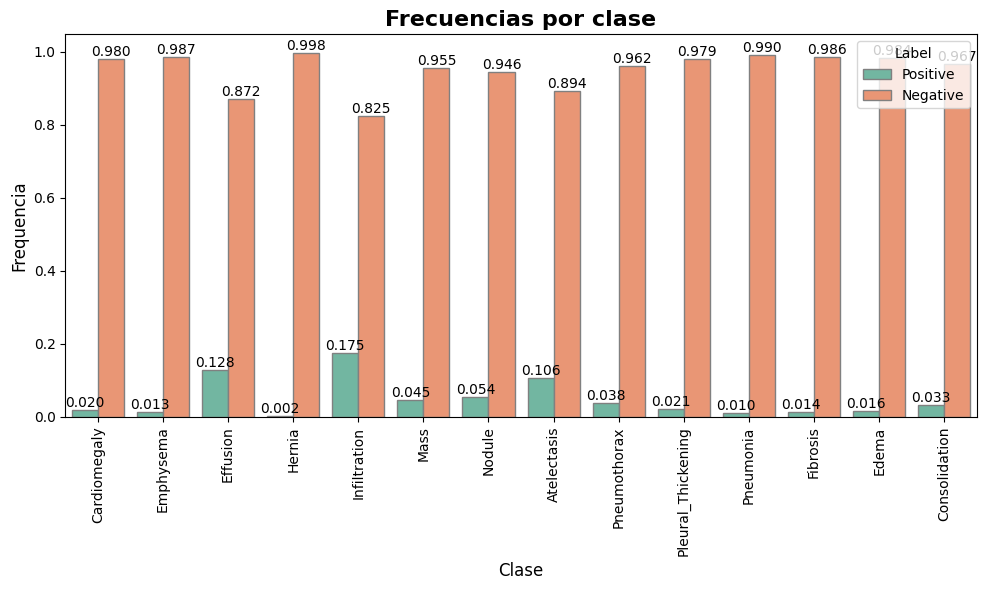

In [ ]:
# Crear los datos
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
new_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)])
data = pd.concat([data, new_data], ignore_index=True)

# Crear un tamaño de figura más grande
plt.figure(figsize=(10, 6))

# Crear el gráfico de barras con seaborn, separando por clase y etiqueta
sns.set_palette("Set2")  # Establecer una paleta de colores atractiva
f = sns.barplot(x="Class", y="Value", hue="Label", data=data, edgecolor='gray')

# Rotar las etiquetas del eje X
plt.xticks(rotation=90, fontsize=10)

# Añadir un título y etiquetas a los ejes
plt.title("Frecuencias por clase", fontsize=16, fontweight='bold')
plt.xlabel("Clase", fontsize=12)
plt.ylabel("Frequencia", fontsize=12)

# Añadir etiquetas de valor en la parte superior de cada barra
for bar in f.containers:
    f.bar_label(bar, fmt='%.3f', label_type='edge', fontsize=10)

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Hay mucho desbalance entre los casos positivos y negativos entre clases, por lo que tendremos que igualar esto.

Como vamos a usar la función de pérdida ponderada, balancearemos el peso especifico de cada clase para que la contribución global de cada clase sea la misma.

Si igualamos los pesos de la clase positiva (pos_weights) a la frecuencia de los ejemplos negativos, y los pesos de la clase negativa (pos_weights) a la frecuencia de los ejemplos negativos, conseguimos balancear todas las clases.

In [ ]:
#Balance de clases

# Calcular los pesos
pos_weights = freq_neg

# Calcular los pesos negativos
neg_weights = freq_pos

# Calcular la contribución positiva
pos_contribution = freq_pos * pos_weights

# Calcular la contribución negativa
neg_contribution = freq_neg * neg_weights

Comprobémoslo graficando de nuevo las dos contribuciones una al lado de la otra:

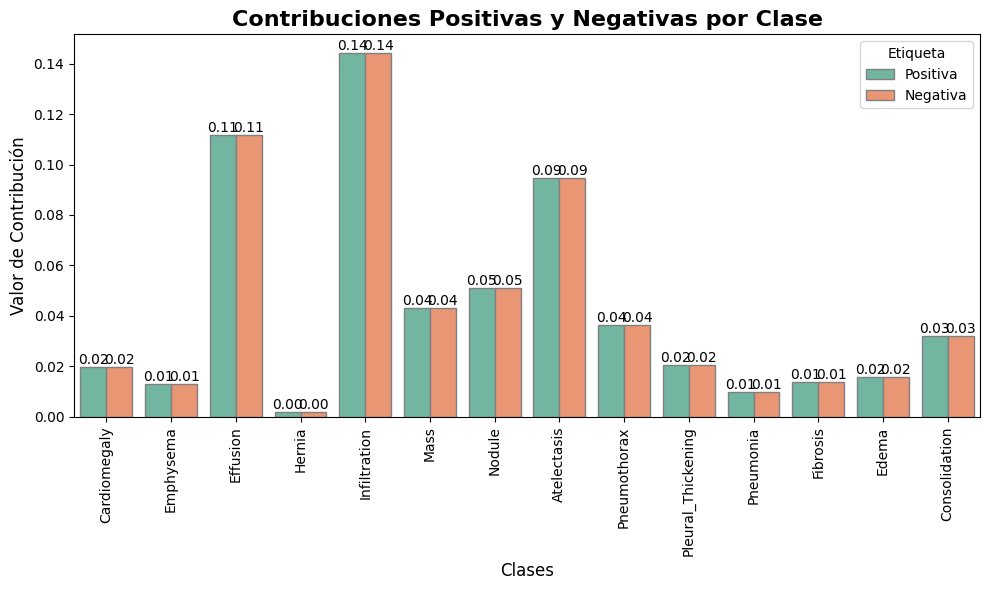

In [ ]:
# Crear DataFrame con los valores positivos
data = pd.DataFrame({"Clase": labels, "Etiqueta": "Positiva", "Valor": pos_contribution})

# Crear DataFrame con los valores negativos
nuevo_data = pd.DataFrame([{"Clase": labels[l], "Etiqueta": "Negativa", "Valor": v} for l, v in enumerate(neg_contribution)])

# Concatenar ambos DataFrames
data = pd.concat([data, nuevo_data], ignore_index=True)

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crear el gráfico de barras con una paleta de colores personalizada
sns.set_palette("Set2")  # Paleta de colores más atractiva
f = sns.barplot(x="Clase", y="Valor", hue="Etiqueta", data=data, edgecolor='gray')

# Rotar las etiquetas del eje X
plt.xticks(rotation=90, fontsize=10)

# Añadir título y etiquetas a los ejes
plt.title("Contribuciones Positivas y Negativas por Clase", fontsize=16, fontweight='bold')
plt.xlabel("Clases", fontsize=12)
plt.ylabel("Valor de Contribución", fontsize=12)

# Añadir etiquetas de valor en la parte superior de cada barra
for barra in f.containers:
    f.bar_label(barra, fmt='%.2f', label_type='edge', fontsize=10)

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Al balancear las clases, las etiquetas positivas y negativas dentro de cada clase aportarán lo mismo a la función de pérdida, que tendremos que calcularla.


<a name= '3-4'></a>
### 3.4. - Función de pérdida ponderada


Definimos la función de perdida ponderada. Es la función más apropiada a la hora de lidiar con el desbalanceo de clases. Para la pérdida multiclase, sumamos la pérdida media de cada clase individual, es decir la negativa y la positiva.


In [ ]:
def weighted_loss(pesos_positivos, pesos_negativos, epsilon=1e-7):

    """
    Crea una función de pérdida ponderada que penaliza las predicciones incorrectas
    con pesos específicos para las clases positivas y negativas.
    """

    def loss(y_true, y_pred):

        loss = 0.0

        # Asegurarse de que y_pred esté recortado para evitar log(0)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

        # Iterar sobre el número de clases
        for i in range(len(pesos_positivos)):
            # Calcular la pérdida positiva para la clase i
            perdida_positiva = -pesos_positivos[i] * y_true[:, i] * tf.math.log(y_pred[:, i])
            # Calcular la pérdida negativa para la clase i
            perdida_negativa = -pesos_negativos[i] * (1 - y_true[:, i]) * tf.math.log(1 - y_pred[:, i])
            # Sumar las pérdidas positiva y negativa
            loss += tf.reduce_mean(perdida_positiva + perdida_negativa)

        return loss

    return loss

<a name='4'></a>
### 4. Desarrollo del modelo - DenseNet121

Vamos a usar un modelo  [DenseNet121](https://www.kaggle.com/pytorch/densenet121) preentrenado que podemos cargar directamente desde Keras y luego añadiremos dos capas sobre él:
1. Una capa `GlobalAveragePooling2D` para obtener la media de las últimas capas de convolución de DenseNet121.
2. Una capa `Dense` con activación `sigmoid` para obtener los logits de predicción de cada una de nuestras clases.
3. Usaremos la funcion de perdida ponderada definida con anterioridad para asignarla a nuestro modelo.

DenseNet121 ha sido entrenado previamente en el conjunto de datos ImageNet, que contiene millones de imágenes y miles de clases. Durante este entrenamiento, el modelo aprende características visuales generales muy útiles, como bordes, texturas, formas y patrones.

Al usar un modelo preentrenado, puedes aprovechar estas características generales y transferir el conocimiento aprendido a tu tarea específica, en lugar de empezar desde cero. Esto es especialmente valioso en este caso ya que se dispone de un conjunto de datos limitado.

In [ ]:
def build_model(train_df, labels, model_file, weight_model_file,learning_rate=1e-4, dropout_rate=0.5):

    """
    Construye un modelo de red neuronal usando DenseNet121 preentrenado como base.
    Calcula pesos de clase para balancear la pérdida y añade capas de Global Average Pooling,
    Dropout y una capa densa final con activación sigmoide. Compila el modelo con el optimizador Adam y la función de pérdida ponderada.
    """

    # Calcular los pesos de clase, tanto positivos como negativos
    class_pos = train_df.loc[:, labels].sum(axis=0)
    class_neg = len(train_df) - class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total

    # Crear el modelo base preentrenado
    base_model = DenseNet121(weights=model_file, include_top=False)
    print("Loaded DenseNet")

    # Añadir una capa de Global Average Pooling
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Añadir una capa de Dropout
    x = Dropout(dropout_rate)(x)

    # Añadir una capa densa final con activación sigmoide
    predictions = Dense(len(labels), activation="sigmoid")(x)
    print("Other layers")

    # Definir el modelo final
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=weighted_loss(neg_weights, pos_weights))
    print("Compiled Model")

    model.load_weights(weight_model_file)

    return model


In [ ]:
# Definir los parámetros
model_file = DATA_DIR + '/models/densenet.hdf5'  # Ruta al archivo del modelo de DenseNet121
weight_model_file = DATA_DIR + '/models/pretrained_model.h5'
learning_rate = 1e-4  # Tasa de aprendizaje
#dropout_rate = 0.5  # Tasa de dropout
dropout_rate_opt = 0.3818224306527116 # Tasa de dropout optimizado

# Llamar a la función para crear el modelo
model = build_model(train_df, labels, model_file, weight_model_file, learning_rate, dropout_rate_opt)

Loaded DenseNet
Other layers
Compiled Model


<a name='4-1'></a>
## 4.1. Ajuste de hiperparámetros usando libreria Optuma


La función objective está diseñada para ser utilizada en un proceso de optimización de hiperparámetros utilizando la librería Optuna. La función ajusta varios hiperparámetros del modelo de red neuronal, entrena el modelo con esos parámetros y evalúa su rendimiento para encontrar los mejores hiperparámetros.
Se van a probar 10 intentos aleatorios de los parámetros:
- droput_rate
- epochs

In [ ]:
def objective(trial):

    """
    Define el objetivo para la optimización de hiperparámetros usando Optuna.
    """



    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    epochs = trial.suggest_int('epochs', 5, 20)

    #model = build_model(learning_rate=learning_rate, dropout_rate=dropout_rate)

    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=epochs,
        verbose=0
    )

    # Evaluar el rendimiento del modelo
    loss = history.history['val_loss'][-1]
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print("Best parameters: ", study.best_params)
print("Best value: ", study.best_value)

[I 2024-09-16 13:09:35,384] A new study created in memory with name: no-name-058c827b-ca3e-4247-b3bf-68899d5d7ce5
<ipython-input-69-e42bf0b09992>:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
[I 2024-09-16 13:17:42,903] Trial 0 finished with value: 0.5668839812278748 and parameters: {'dropout_rate': 0.22920863688648163, 'epochs': 8}. Best is trial 0 with value: 0.5668839812278748.
[I 2024-09-16 13:38:10,136] Trial 1 finished with value: 0.455246239900589 and parameters: {'dropout_rate': 0.20234542980491854, 'epochs': 20}. Best is trial 1 with value: 0.455246239900589.
[I 2024-09-16 13:45:51,006] Trial 2 finished with value: 0.403510719537735 and parameters: {'dropout_rate': 0.34782641117653446, 'epochs': 9}. Best is trial 2 with value: 0.403510719537735.
[I 2024-09-16 13:53:41,30

Best parameters:  {'dropout_rate': 0.3818224306527116, 'epochs': 13}
Best value:  0.10384250432252884


Parámetros optimos del nuevo modelo:

- Best parameters:  {'dropout_rate': 0.3818224306527116, 'epochs': 13}
- Best value:  0.10384250432252884

<a name='4-2'></a>
## 4.2. Definición de Callbacks y entrenamiento del modelo optimizado

1. `ModelCheckpoint` callback para controlar la métrica `val_loss` del modelo y mantener una instantánea del modelo.

2. `TensorBoard` para monitorizar la ejecución en tiempo real.

3. `EarlyStopping` para detener el trabajo de entrenamiento cuando el modelo deja de mejorar. Con `patience` indicamos el número de épocas en las que el modelo no mejora tras las cuales se termina el entrenamiento. Este callback también puede restaurar convenientemente los pesos para la mejor métrica al final del entrenamiento de tu modelo.



In [ ]:
#Definición de Callbacks:

#1. ModelCheckpoint: Guarda el modelo con la mejor métrica `loss`
model_checkpoint = ModelCheckpoint(
    'best_model.keras',             # Ruta del archivo donde se guardará el modelo
    monitor='loss',                 # Métrica a monitorear
    save_best_only=True,            # Solo guardar el modelo si la métrica mejora
    mode='min',                     # Mínimo valor de loss
    verbose=1                       # Mostrar mensajes durante el guardado
)

# 2. TensorBoard: Para monitorizar la ejecución en tiempo real
tensorboard = TensorBoard(
    log_dir='logs',                 # Directorio donde se guardarán los logs para TensorBoard
    histogram_freq=1,               # Frecuencia para almacenar histogramas
    update_freq='epoch',            # Actualizar cada época
    embeddings_freq=1,              # Frecuencia para almacenar embeddings
    profile_batch=2                 # Número de batches para el perfil de rendimiento (opcional)
)


# 3. EarlyStopping: Detiene el entrenamiento cuando el modelo deja de mejorar
early_stopping = EarlyStopping(
    monitor='loss',                 # Métrica a monitorear
    patience=5,                     # Número de épocas para esperar sin mejora antes de detener el entrenamiento
    restore_best_weights=True,      # Restaurar los pesos del mejor modelo
    mode='min',                     # Mínimo valor de loss`
    verbose=1                       # Mostrar mensajes durante la detención temprana
)


Epoch 1/13


<ipython-input-17-7cb70e3066ba>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  perdida_positiva = -pesos_positivos[i] * y_true[:, i] * tf.math.log(y_pred[:, i])
<ipython-input-17-7cb70e3066ba>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  perdida_negativa = -pesos_negativos[i] * (1 - y_true[:, i]) * tf.math.log(1 - y_pred[:, i])
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass th

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.6892
Epoch 1: loss improved from inf to 0.66216, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 696s 3s/step - loss: 0.6889 - val_loss: 1.0906
Epoch 2/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.6561
Epoch 2: loss improved from 0.66216 to 0.65021, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 438ms/step - loss: 0.6561 - val_loss: 1.3326
Epoch 3/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - loss: 0.6535
Epoch 3: loss improved from 0.65021 to 0.64385, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 440ms/step - loss: 0.6535 - val_loss: 1.5148
Epoch 4/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 0.5884
Epoch 4: loss improved from 0.64385 to 0.62238, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 438ms/step - loss: 0.5886 - val_loss: 1.4283
Epoch 5/13
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - loss: 0.6537
Epoch 5: loss did not improve from 0.62

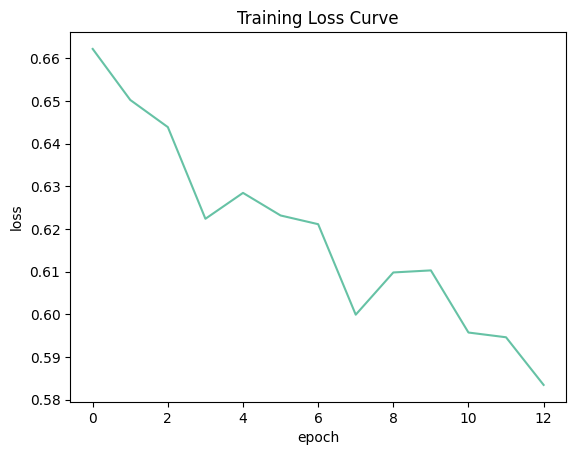

In [ ]:
# Entrenamiento del modelo con todos los callbacks
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=13,
    callbacks=[model_checkpoint, tensorboard, early_stopping]
)

# Mostrar la curva de pérdida
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

<a name='4-3'></a>
## 4.3. Guardar y cargar modelo

Sección para almacenar o cargar el modelo ya entrenado durante su desarrollo

In [ ]:
# MODULO para CARGAR/GUARDAR MODELO

# Guardar modelo en formato SavedModel (Keras 3)
# model.save(HOME_DIR + '/models/my_model.keras')

# Cargar el modelo en formato SavedModel
# Cargar el modelo incluyendo los objetos personalizados
# model = load_model(HOME_DIR + '/models/my_model.keras',
#                     custom_objects={'loss': weighted_loss(neg_weights, pos_weights)})

<a name='5'></a>
## 5. Prediction and Evaluation

Vamos a realizar las predicciones con el modelo ya entrenado

In [ ]:
# Realiza las predicciones en el conjunto de test
predicted_vals = model.predict(test_generator, steps=len(test_generator))

53/53 ━━━━━━━━━━━━━━━━━━━━ 357s 7s/step


In [ ]:
print(predicted_vals[:5])

[[0.8908062  0.08546451 0.6554641  0.13482493 0.76114917 0.10721833
  0.2482013  0.7439049  0.25957066 0.4553378  0.7859124  0.17976736
  0.85958135 0.59566414]
 [0.19197583 0.05773006 0.7722649  0.05014151 0.62976617 0.19991164
  0.20105216 0.949959   0.07069922 0.17858526 0.6409379  0.02735307
  0.45601678 0.78132915]
 [0.09631974 0.06018909 0.08660948 0.22516596 0.49494606 0.07282208
  0.28528923 0.7503683  0.35420436 0.37597075 0.4450945  0.26797122
  0.15922177 0.22222242]
 [0.11440928 0.5348404  0.6094711  0.5689706  0.65928113 0.7952331
  0.40613115 0.4861072  0.68977964 0.88197124 0.49431834 0.6963268
  0.04173897 0.7099147 ]
 [0.09618627 0.92397577 0.10466449 0.82276845 0.264813   0.118778
  0.19680198 0.51247567 0.59865886 0.7424464  0.20750259 0.78869873
  0.02218756 0.12337215]]


In [ ]:
# Convertir las predicciones en etiquetas binarias (0 o 1)
predicted_labels = (predicted_vals >= 0.5).astype(int)

# Obtener los valores verdaderos del conjunto de test
true_labels = test_df[labels].values

# Obtener la columna de IDs de las imágenes
image_ids = test_df['Image'].values  # Asegúrate de que la columna tenga el nombre correcto

# Crear un DataFrame con las etiquetas predichas, las verdaderas y las IDs de las imágenes
results_df = pd.DataFrame(predicted_labels, columns=labels)
results_df['True_Labels'] = list(true_labels)
results_df['Image_ID'] = image_ids

# Reorganizar para que la columna 'Image_ID' esté al inicio
results_df = results_df[['Image_ID'] + list(labels) + ['True_Labels']]

# Mostrar las primeras filas del DataFrame con las predicciones, etiquetas verdaderas e IDs de imágenes
print(results_df.head())


           Image_ID  Cardiomegaly  Emphysema  Effusion  Hernia  Infiltration  \
0  00021463_005.png             1          0         1       0             1   
1  00019733_002.png             0          0         1       0             1   
2  00021463_001.png             0          0         0       0             0   
3  00017136_020.png             0          1         1       1             1   
4  00027477_000.png             0          1         0       1             0   

   Mass  Nodule  Atelectasis  Pneumothorax  Pleural_Thickening  Pneumonia  \
0     0       0            1             0                   0          1   
1     0       0            1             0                   0          1   
2     0       0            1             0                   0          0   
3     1       0            0             1                   1          0   
4     0       0            1             1                   1          0   

   Fibrosis  Edema  Consolidation                       

<a name='5-1'></a>
### 5.1 Curva ROC y AUROC

Para evaluar el rendimiento de nuestro modelo, usaremos la curva ROC que nos da. Vamos a calcular la métrica del área bajo la curva (AUC) tomando en consideración la curva ROC. Una curva que está más a la izquierda y en la parte superior tiene más «área» debajo de ella, e indica que el modelo está funcionando mejor.

In [ ]:
def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []

    plt.figure(figsize=(12, 8))  # Ajusta el tamaño de la figura según sea necesario

    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]

            if len(set(gt)) < 2:
                # No se puede calcular la curva ROC si no hay ambas clases en los datos
                print(f"Insuficientes clases para {labels[i]}. Solo hay una clase en los datos.")
                continue

            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)

            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)

            plt.plot(fpr_rf, tpr_rf, label=f"{labels[i]} ({round(auc_roc, 3)})")
        except ValueError as e:
            print(f"Error en {labels[i]}: {e}")
        except Exception as e:
            print(f"Error inesperado en {labels[i]}: {e}")

    plt.plot([0, 1], [0, 1], 'k--', label='Random')  # Línea diagonal para referencia
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curvas ROC para todas las clases')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    return auc_roc_vals

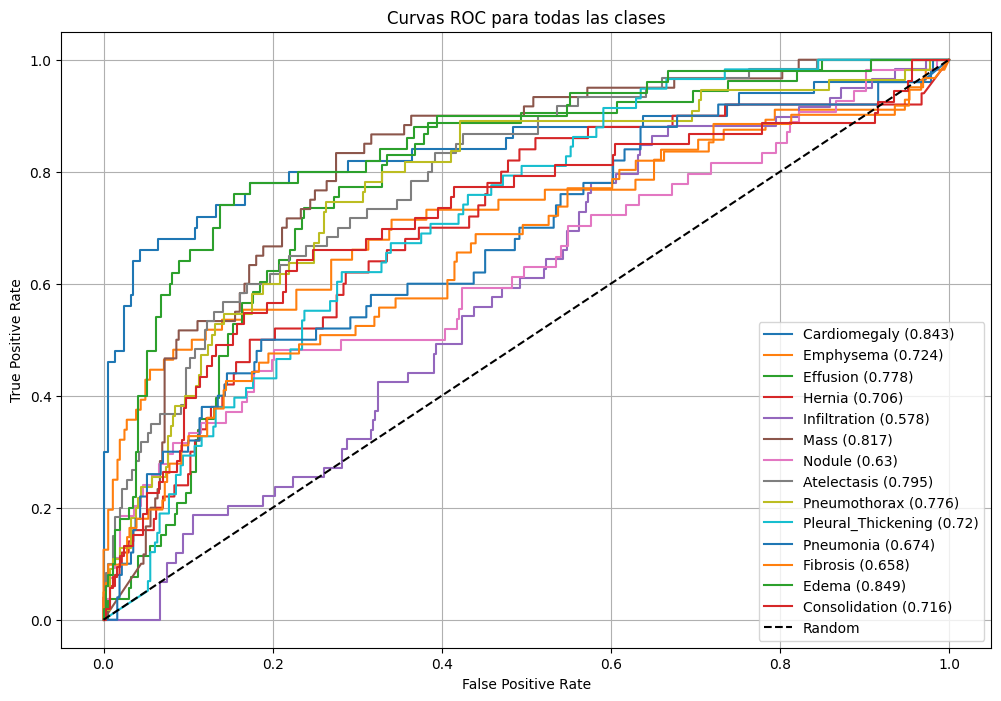

In [ ]:
# VALORES DE TEST CON MODELO VCM313 OPTIMIZADO
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

<a name='6'></a>
## 6. Productivizar el modelo

<a name='6-1'></a>
## 6.1. GradCAM

El uso de GradCAM (Gradient-weighted Class Activation Mapping) es muy útil para analizar los resultados de la detección de patologías en imágenes de rayos X, ya que proporciona una visualización intuitiva de cómo un modelo de aprendizaje profundo llega a sus predicciones.

- 1. Interpretabilidad del modelo: GradCAM ayuda a visualizar qué áreas de la imagen influyen más en la predicción del modelo, facilitando la comprensión de sus decisiones por parte de expertos.

- 2. Validación médica: Permite validar si el modelo está enfocándose en las áreas correctas de la imagen, como lesiones, garantizando decisiones basadas en las razones adecuadas.

- 3. Detección de fallos: GradCAM ayuda a identificar errores del modelo mostrando si se enfocó en las áreas relevantes o si ignoró características importantes.

- 4. Explicaciones visuales: Proporciona visualizaciones que facilitan la interpretación de los resultados por parte de los profesionales de la salud, mejorando la colaboración con la IA.

- 5. Mejora del desarrollo: Ofrece información visual sobre el comportamiento de las capas del modelo, lo que permite ajustar y optimizar su rendimiento de forma más precisa

Antes de proceder a definir la funcion de GradCAM, necesitamos varias funciones auxiliares para preparar las imágenes.

`media_std_batch`: Calcula la media y desviación estándar de un lote de imágenes para su normalización.

`load_image_norm`: Carga una imagen, la normaliza usando la media y desviación estándar, y la prepara para el modelo.

`load_image`: Carga una imagen, y opcionalmente la normaliza si se indica, para su uso en el modelo.

Esta función calcula la media y la desviación estándar de un lote de imágenes para normalizar los datos de entrada.

In [ ]:
sns.reset_defaults()

def media_std_batch(df, H=320, W=320):

    sample_data = []
    # Itera sobre una muestra de 100 imágenes del DataFrame
    for idx, img in enumerate(df.sample(100)["Image"].values):
        path = IMAGE_DIR + img
        # Carga y redimensiona la imagen, luego la convierte en un array numpy
        sample_data.append(np.array(image.load_img(path, target_size=(H, W))))

    # Calcula la media y la desviación estándar del primer array de la muestra
    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

mean, std = media_std_batch(train_df)

Esta función carga una imagen desde un archivo, la normaliza usando la media y la desviación estándar calculadas, y la prepara para el modelo.

In [ ]:
def load_image_norm(path, mean, std, H=320, W=320):

    x = image.load_img(path, target_size=(H, W))
    # Normaliza la imagen restando la media y dividiendo por la desviación estándar
    x -= mean
    x /= std
    x = np.expand_dims(x, axis=0)  # Añade una dimensión para el batch
    return x

Esta función carga una imagen desde un archivo, y la normaliza usando la media y la desviación estándar calculadas.

In [ ]:
def load_image(path, df, preprocess=True, H=320, W=320):

    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        mean, std = media_std_batch(df, H=H, W=W)
        # Normaliza la imagen
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)  # Añade una dimensión para el batch
    return x

El proceso de GradCAM es el siguiente:

- Convertir la imagen a un formato que el modelo entienda:

Primero, tomamos la imagen de rayos X y la convertimos a tensor para que el modelo pueda trabajar con ella. Básicamente, transformamos la imagen en una tabla de números que el modelo puede procesar.

- Preparar el cálculo de gradientes:

Se mide cuanto influye cada parte de la imagen en la predicción final, es decir, qué áreas son las más importantes.

- Pasar la imagen por el modelo:

La imagen se procesa a través del modelo, y éste nos da una predicción. A la vez, obtenemos las "activaciones", que son las señales generadas por una capa interna del modelo que muestra qué partes de la imagen han activado más las neuronas del modelo.

- Calcular los gradientes:

Calculamos cómo cambian estas activaciones en respuesta a la salida del modelo. Esto nos ayuda a identificar qué partes de la imagen son las más relevantes para tomar la decisión (por ejemplo, detectar una enfermedad).

- Promediar los gradientes:

Promediamos esos gradientes para entender qué canales específicos dentro de la red son los más importantes. Es una forma de simplificar la información que obtenemos.
Generar el mapa de activación:

Con la información que hemos obtenido, creamos un mapa que muestra claramente qué partes de la imagen el modelo considera clave para hacer su predicción.

- Ajustar y normalizar el mapa:

Finalmente, ajustamos el mapa para que se sobreponga a la imagen original y lo normalizamos, es decir, lo convertimos en una imagen clara y fácil de interpretar, donde las áreas más relevantes aparecen resaltadas.

In [ ]:
def grad_cam(input_model, image, category_index, layer_name):
    """
    Método GradCAM para visualizar la saliencia de la entrada.

    """

    # Asegurarse de que la imagen tiene la forma correcta y convertirla a tensor
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

    # Crear un modelo que produzca las activaciones de la capa especificada
    layer = input_model.get_layer(layer_name)
    activation_model = tf.keras.Model(inputs=input_model.input, outputs=[layer.output, input_model.output])

    with tf.GradientTape() as tape:
        # Pase hacia adelante
        layer_output, predictions = activation_model(image_tensor)
        class_output = predictions[:, category_index]

        # Registrar las operaciones para calcular gradientes
        tape.watch(layer_output)

    # Calcular los gradientes de la salida de la clase respecto a la salida de la capa
    grads = tape.gradient(class_output, layer_output)

    # Calcular la media de los gradientes a través de las dimensiones espaciales
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Obtener la salida de la capa
    layer_output = layer_output[0].numpy()  # Convertir a array de numpy

    # Multiplicar los gradientes promediados por la salida de la capa
    cam = np.dot(layer_output, pooled_grads.numpy())  # Convertir pooled_grads a numpy

    # Aplicar ReLU y redimensionar a las dimensiones originales de la imagen
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (image.shape[2], image.shape[1]), interpolation=cv2.INTER_LINEAR)

    # Normalizar el CAM
    cam = cam / np.max(cam)

    return cam


In [ ]:
def compute_gradcam(model, img, mean, std, data_dir, df,
                    labels, selected_labels, layer_name):
    """
    Calcula el GradCAM para muchas etiquetas especificadas para una imagen.
    Este método utilizará la función `grad_cam`.
    """

    # Ruta completa de la imagen
    img_path = data_dir + img

    # Cargar y normalizar la imagen
    preprocessed_input = load_image_norm(img_path, mean, std)

    # Obtener las predicciones del modelo
    predictions = model.predict(preprocessed_input)

    # Imprimir las etiquetas verdaderas para la imagen
    ground_truth_labels = np.take(labels, np.nonzero(df[df["Image"] == img][labels].values[0])[0])

    #Verificar si ground_truth_labels está vacío o None

    if len(ground_truth_labels) == 0:
        ground_truth_labels = ["Ninguna"]
    else:
        ground_truth_labels = list(ground_truth_labels)

    print("Patología: ", ", ".join(ground_truth_labels))

    # Número de subgráficos necesarios: 1 para la imagen original + len(selected_labels) para los GradCAMs
    num_plots = 1 + len(selected_labels)

    # Configurar el tamaño de la figura
    plt.figure(figsize=(20, 15))

    # Mostrar la imagen original
    plt.subplot(1, num_plots, 1)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img_path, df, preprocess=False), cmap='gray')

    # Iterar sobre las etiquetas seleccionadas para calcular y mostrar GradCAM
    for j, label in enumerate(selected_labels):
        if label in labels:
            # Obtener el índice de la etiqueta en la lista de etiquetas
            label_index = labels.index(label)

            # Calcular GradCAM para la etiqueta actual
            gradcam = grad_cam(model, preprocessed_input, label_index, layer_name)

            print(f"Generando GradCAM para la clase {label} (p={predictions[0][label_index]:.2f})")

            # Mostrar la imagen original con el GradCAM superpuesto
            plt.subplot(1, num_plots, j + 2)
            plt.title(f"{label}: {predictions[0][label_index]:.2f}")
            plt.axis('off')
            img_original = load_image(img_path, df, preprocess=False)
            plt.imshow(img_original, cmap='gray')
            plt.imshow(gradcam, cmap='magma', alpha=0.5)  # Superponer GradCAM sobre la imagen original

    # Mostrar todos los gráficos
    plt.show()

In [ ]:
def name_last_layer(modelo):
    """
    Obtiene el nombre de la última capa Concatenate en el modelo.
    """
    last_layer = None
    # Iterar sobre todas las capas del modelo
    for layer in modelo.layers:
        # Verificar si la capa es del tipo Concatenate
        if isinstance(layer, Concatenate):
            # Actualizar el nombre de la última capa Concatenate encontrada
            last_layer = layer.name

    return last_layer

# Ejemplo de uso:
last_layer = name_last_layer(model)
print("Nombre de la última capa Concatenate:", last_layer)

Nombre de la última capa Concatenate: conv5_block16_concat


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Patología:  Nodule
Generando GradCAM para la clase Nodule (p=0.59)
Generando GradCAM para la clase Edema (p=0.03)
Generando GradCAM para la clase Fibrosis (p=0.08)


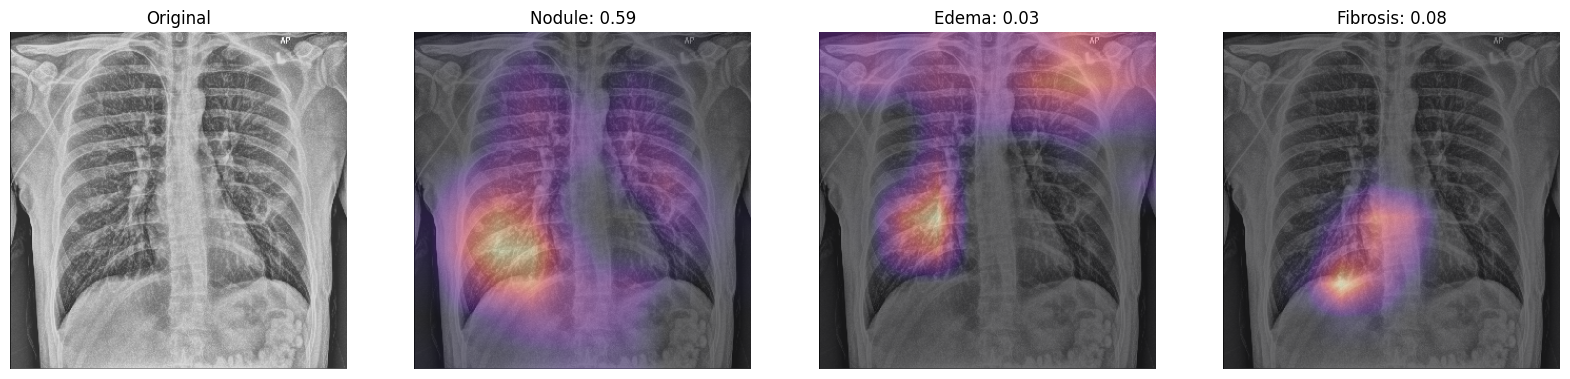

In [ ]:
#Imagen 1

image_filename = '00026469_006.png'
labels_to_show = ['Nodule','Edema', 'Fibrosis']
compute_gradcam(model, image_filename, mean, std, IMAGE_DIR, train_df, labels, labels_to_show, last_layer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Patología:  Consolidation
Generando GradCAM para la clase Consolidation (p=0.46)
Generando GradCAM para la clase Edema (p=0.07)
Generando GradCAM para la clase Fibrosis (p=0.04)


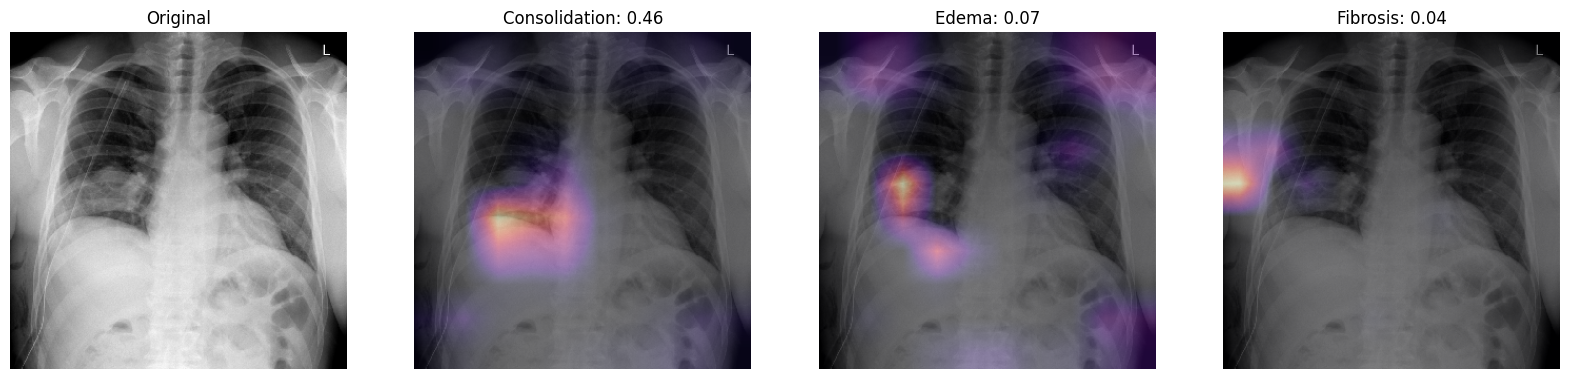

In [ ]:
# Imagen 2

image_filename = '00023296_003.png'
labels_to_show = ['Consolidation','Edema', 'Fibrosis']
compute_gradcam(model, image_filename, mean, std, IMAGE_DIR, train_df, labels, labels_to_show, last_layer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Patología:  Ninguna
Generando GradCAM para la clase Mass (p=0.16)
Generando GradCAM para la clase Nodule (p=0.45)
Generando GradCAM para la clase Fibrosis (p=0.24)


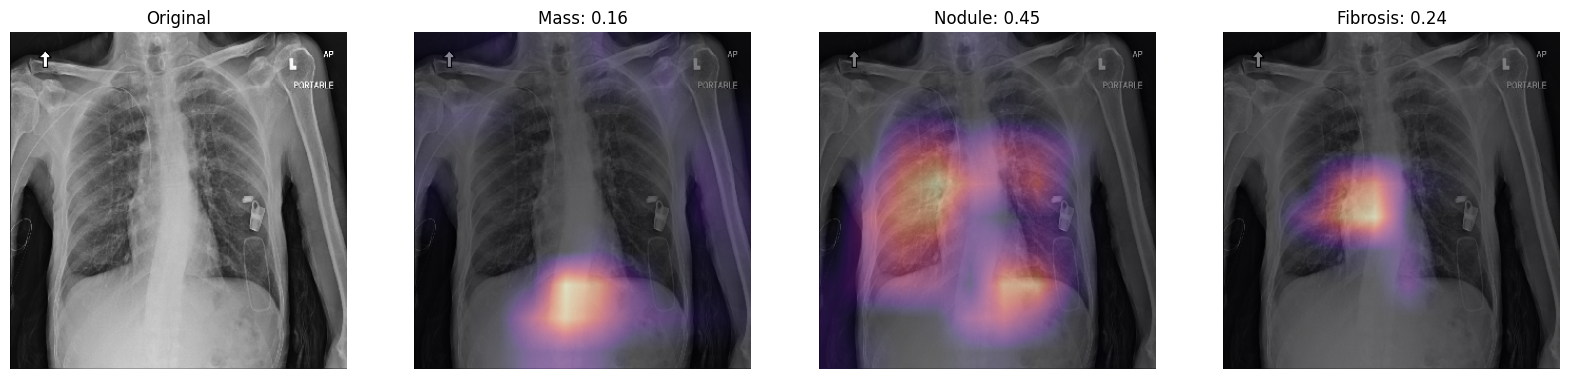

In [ ]:
# Imagen 3

image_filename = '00019108_000.png'
labels_to_show = ['Mass','Nodule', 'Fibrosis']
compute_gradcam(model, image_filename, mean, std, IMAGE_DIR, train_df, labels, labels_to_show, last_layer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Patología:  Effusion, Mass
Generando GradCAM para la clase Mass (p=0.97)
Generando GradCAM para la clase Effusion (p=0.98)
Generando GradCAM para la clase Fibrosis (p=0.75)


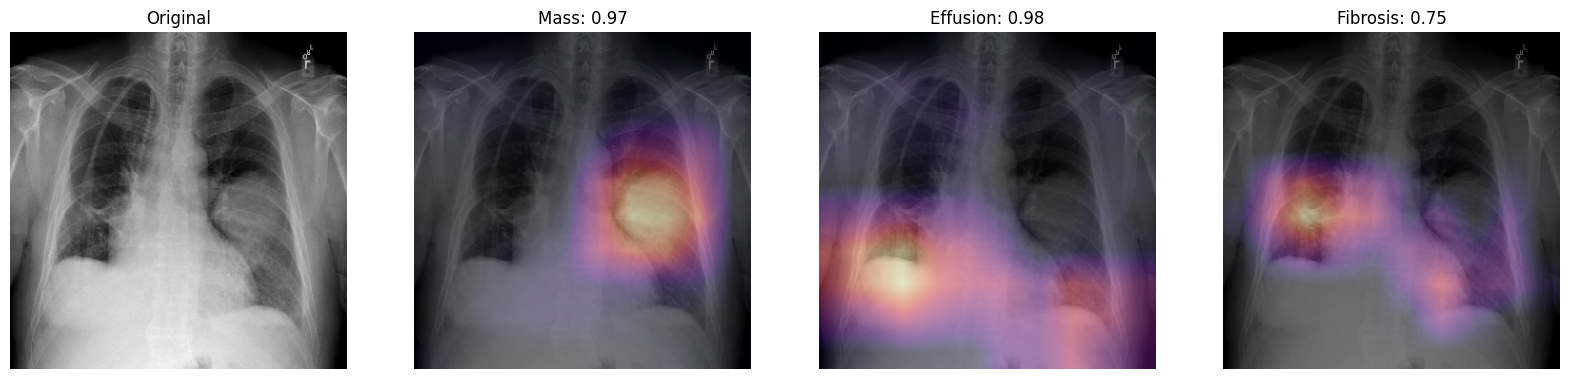

In [ ]:
# Imagen 4

image_filename = '00014919_017.png'
labels_to_show = ['Mass','Effusion', 'Fibrosis']
compute_gradcam(model, image_filename, mean, std, IMAGE_DIR, train_df, labels, labels_to_show, last_layer)